In [1]:
import os
import pandas as pd
import numpy as np
import math
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy.stats import shapiro
from scipy.stats import zscore
from scipy.stats import levene
from scipy.stats import boxcox
from scipy.stats import norm
from scipy.stats import probplot
from distfit import distfit

In [2]:
original_data = pd.read_csv('survey_results.csv', index_col=0)
original_df = df = pd.DataFrame(original_data) 
original_df.head()

,group,id,question,answer,time,confidence,correct_answer,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,faster_timers,slider_timers,zoom_interactions,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,3,True,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",[],[],[],16,0,162,0,0,0
1,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t3_single_si,1,86,5,1,True,"[156, 249, 310, 327, 1317, 177, 248, 243, 164,...","[4407, 3694, 3410, 3901, 2870, 701, 3894, 4036]",[],[],[],[],26,8,0,0,0,0
2,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_tl,3,62,5,3,True,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10,0,23,0,0,10
3,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_jp,5,605,5,3,False,[],[],"[1947, 263, 396, 9420, 464, 364, 25930, 304, 8...",[],[],[],0,0,100,0,0,0
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,2,True,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",[],[],[],0,0,10,0,0,0


In [3]:
wrong_answers = ['0d215911-e63c-46ad-a063-653b709f8253',
'037605fd-b893-4885-b04a-8e9c2bed8a1a',
'1039ad57-5293-4af8-acce-89edd244cc7a',
'86bfd834-db2c-44ee-8300-8f182be02533',
'224c8817-b026-4280-b546-04d6cb5388f7',
'2e4f721a-71de-465c-97c1-4bd8a4c7a5d4',
'ffadb36b-5051-4684-b9cf-ed767a599434',
'f357cda5-2402-4fd5-93ff-d8d6ed2a566d']

In [4]:
# remove id's who answered control questions 2&3 wrong
original_df = original_df[~original_df['id'].isin(wrong_answers)]

In [5]:
original_df['network_enc'] = original_df['question'].str.split('_').str[0]
original_df['task_type'] = original_df['question'].str.split('_').str[1]
original_df['task_entity'] = original_df['question'].str.split('_').str[2]
original_df['temporal_enc'] = original_df['question'].str.split('_').str[3]
original_df['correct'] = original_df['correct'].apply(str).str.lower()
original_df['time'] = original_df['time'].apply(int)

original_df = original_df.drop(['question', 'id', 'correct_answer'], axis=1)
original_df.head()

,group,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,faster_timers,...,zoom_interactions,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc
0,B,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",[],[],...,16,0,162,0,0,0,m,t1,clique,si
1,B,1,86,5,true,"[156, 249, 310, 327, 1317, 177, 248, 243, 164,...","[4407, 3694, 3410, 3901, 2870, 701, 3894, 4036]",[],[],[],...,26,8,0,0,0,0,nl,t3,single,si
2,B,3,62,5,true,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",[],[],...,10,0,23,0,0,10,m,t1,single,tl
3,B,5,605,5,false,[],[],"[1947, 263, 396, 9420, 464, 364, 25930, 304, 8...",[],[],...,0,0,100,0,0,0,m,t3,clique,jp
4,B,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",[],[],...,0,0,10,0,0,0,m,t1,single,si


## Functions

In [6]:
def shapiro_wilk(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [7]:
def levene_test(arr1, arr2, arr3, arr4, center):
    stat, p = levene(arr1, arr2, arr3, arr4, center=center)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

In [8]:
def test_distribution(time_orig, time_trans):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    prob = probplot(time_orig, dist=norm, plot=ax1)
    prob = probplot(time_trans, dist=norm, plot=ax2)

    ax1.set_title('Original Data')
    ax1.set_ylabel('Time Taken')
    ax2.set_title('Transformed Data, λ = %s' % -0.322);
    ax2.set_ylabel('');

In [9]:
def box_cox(df):
    df_trans, lmbda = boxcox(df)
    return df_trans

In [10]:
def remove_outlier_IQR(df, col, lower, upper):
    Q1=df[col].quantile(lower/100)
    Q3=df[col].quantile(upper/100)
    IQR=Q3-Q1
    
    df_final=df[~((df[col]<(Q1-1.5*IQR)) | (df[col]>(Q3+1.5*IQR)))]
    return df_final

In [11]:
def plot_hist(data):
    pyplot.hist(data, bins="sqrt")

In [12]:
def transform_data(df):
    df['time_trans'] = box_cox(df['time'])
    test_distribution(df['time'], df['time_trans'])

    shapiro_wilk(df['time_trans'])

In [13]:
def check_dist(df):
    dist = distfit(alpha=0.05, stats='RSS')
    dist.fit_transform(df,verbose=1)
    dist.plot(verbose=1)
    dist.summary

## H1

In [14]:
# step 1: create data groups (nl vs m)
h1_nl_df = original_df.loc[original_df['network_enc'] == 'nl']
h1_m_df = original_df.loc[original_df['network_enc'] == 'm']

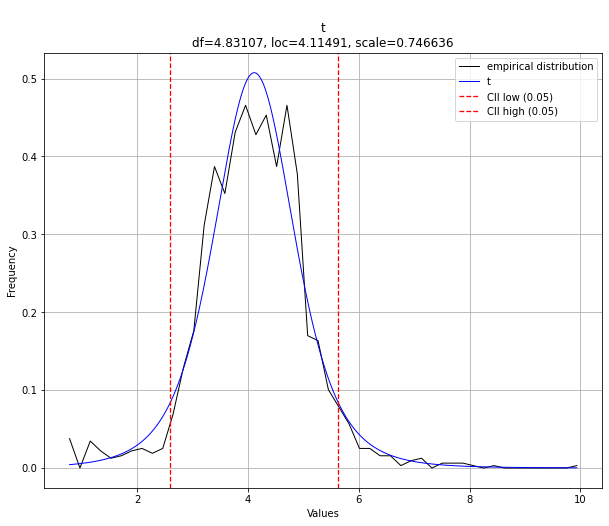

In [15]:
# step 2: check data distribution
check_dist(box_cox(h1_nl_df['time']))

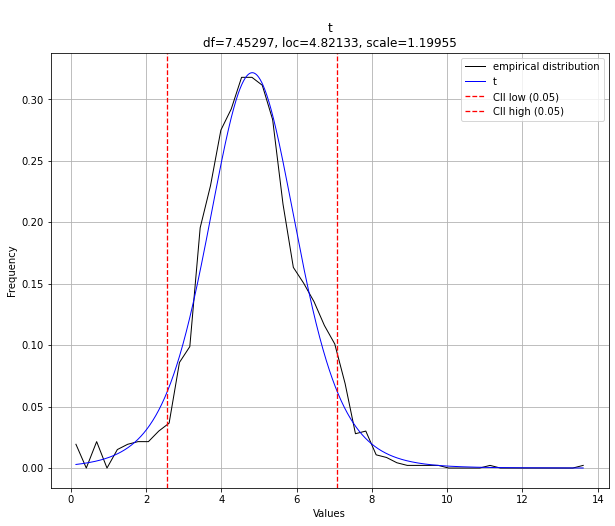

In [16]:
# step 2: check data distribution
check_dist(box_cox(h1_m_df['time']))

Statistics=0.965, p=0.000
Sample does not look Gaussian (reject H0)


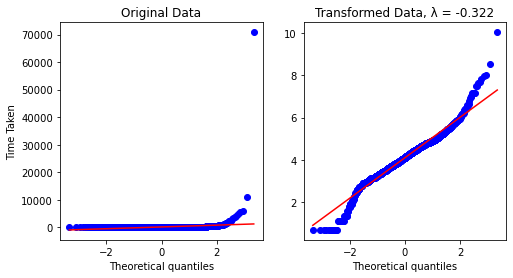

In [17]:
# step 3: transform using box cox and compare before and after
transform_data(h1_nl_df)

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


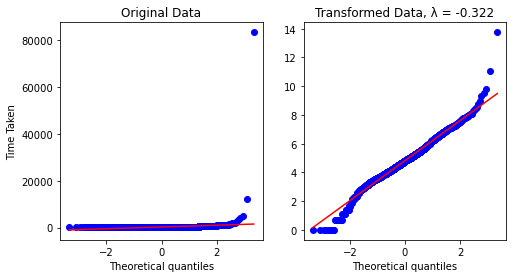

In [18]:
# step 3: transform using box cox and compare before and after
transform_data(h1_m_df)

Statistics=0.974, p=0.000
Sample does not look Gaussian (reject H0)


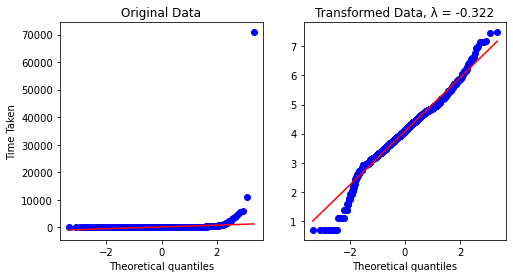

In [19]:
# step 4: IQR outlier removal
h1_nl_df_cleansed = remove_outlier_IQR(h1_nl_df, 'time_trans', 15, 85)
test_distribution(h1_nl_df['time'], h1_nl_df_cleansed['time_trans'])
shapiro_wilk(h1_nl_df_cleansed['time_trans'])

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


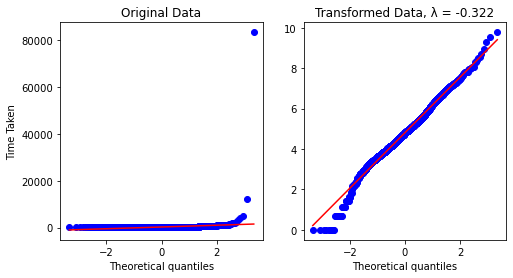

In [20]:
# step 4: IQR outlier removal
h1_m_df_cleansed = remove_outlier_IQR(h1_m_df, 'time_trans', 15, 85)
test_distribution(h1_m_df['time'], h1_m_df_cleansed['time_trans'])
shapiro_wilk(h1_m_df_cleansed['time_trans'])

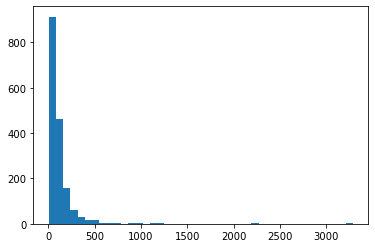

In [21]:
plot_hist(h1_nl_df_cleansed['time'])

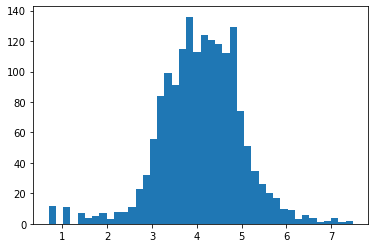

In [22]:
plot_hist(h1_nl_df_cleansed['time_trans'])

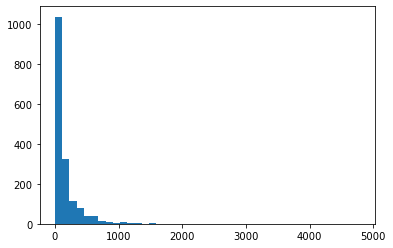

In [23]:
plot_hist(h1_m_df_cleansed['time'])

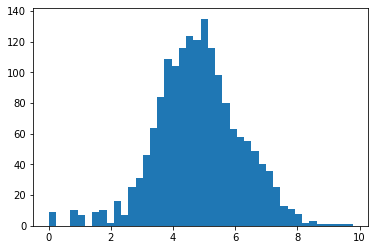

In [24]:
plot_hist(h1_m_df_cleansed['time_trans'])

In [25]:
# step 5: further subdivide based on task type
# nl vs m for t1
h1_nl_df_t1 = h1_nl_df.loc[h1_nl_df['task_type'] == 't1']
h1_m_df_t1 = h1_m_df.loc[h1_m_df['task_type'] == 't1']

# nl vs m for t2
h1_nl_df_t1 = h1_nl_df.loc[h1_nl_df['task_type'] == 't2']
h1_m_df_t1 = h1_m_df.loc[h1_m_df['task_type'] == 't2']

# nl vs m for t3
h1_nl_df_t1 = h1_nl_df.loc[h1_nl_df['task_type'] == 't3']
h1_m_df_t1 = h1_m_df.loc[h1_m_df['task_type'] == 't3']

## H2

In [26]:
# step 1: create data groups (si vs jp vs tl vs an)
h2_si_df = original_df.loc[original_df['temporal_enc'] == 'si']
h2_jp_df = original_df.loc[original_df['temporal_enc'] == 'jp']
h2_tl_df = original_df.loc[original_df['temporal_enc'] == 'tl']
h2_an_df = original_df.loc[original_df['temporal_enc'] == 'an']

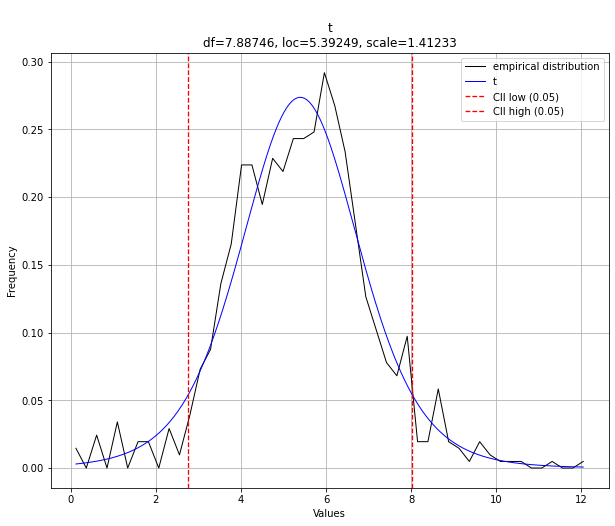

In [27]:
# step 2: check data distribution
check_dist(box_cox(h2_si_df['time']))

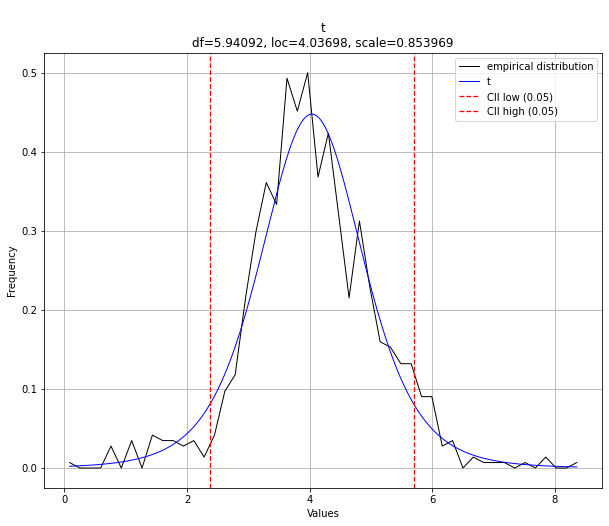

In [28]:
# step 2: check data distribution
check_dist(box_cox(h2_jp_df['time']))

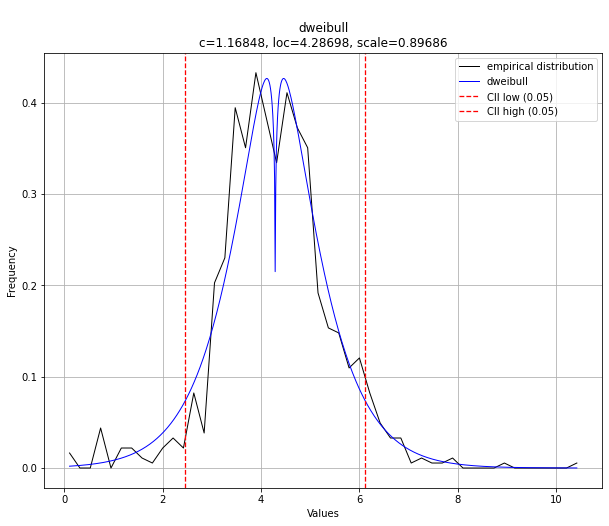

In [29]:
# step 2: check data distribution
check_dist(box_cox(h2_tl_df['time']))

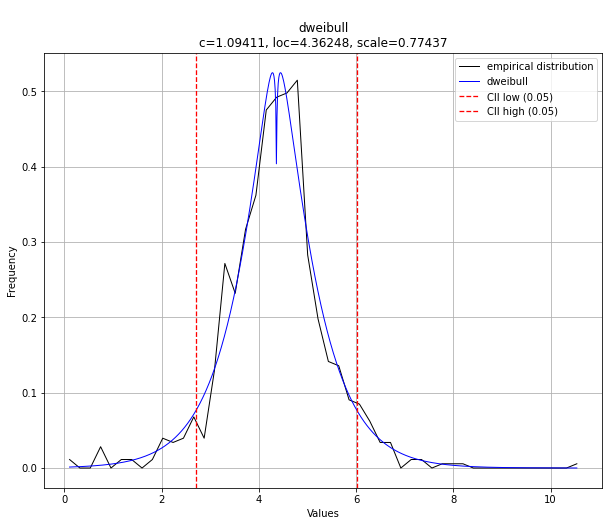

In [30]:
# step 2: check data distribution
check_dist(box_cox(h2_an_df['time']))

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


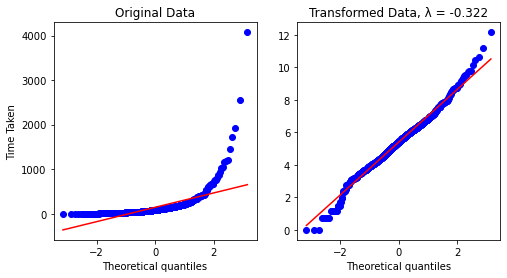

In [31]:
# step 3: transform using box cox and compare before and after
transform_data(h2_si_df)

Statistics=0.982, p=0.000
Sample does not look Gaussian (reject H0)


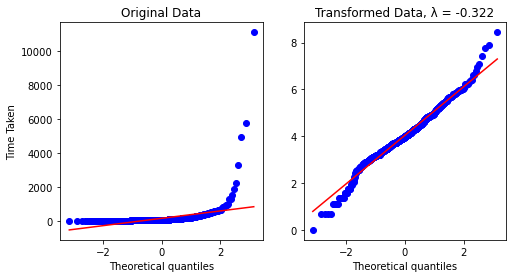

In [32]:
# step 3: transform using box cox and compare before and after
transform_data(h2_jp_df)

Statistics=0.971, p=0.000
Sample does not look Gaussian (reject H0)


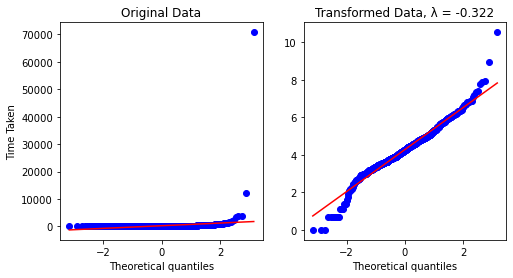

In [33]:
# step 3: transform using box cox and compare before and after
transform_data(h2_tl_df)

Statistics=0.962, p=0.000
Sample does not look Gaussian (reject H0)


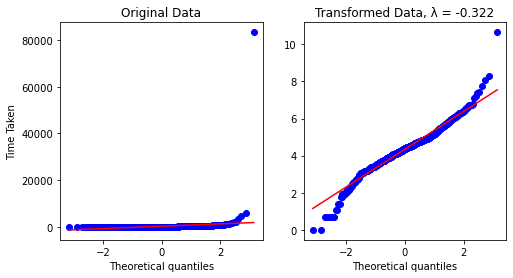

In [34]:
# step 3: transform using box cox and compare before and after
transform_data(h2_an_df)

Statistics=0.991, p=0.000
Sample does not look Gaussian (reject H0)


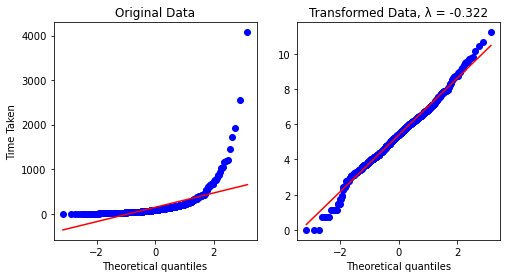

In [35]:
# step 4: IQR outlier removal
h2_si_df_cleansed = remove_outlier_IQR(h2_si_df, 'time_trans', 15, 85)
test_distribution(h2_si_df['time'], h2_si_df_cleansed['time_trans'])
shapiro_wilk(h2_si_df_cleansed['time_trans'])

Statistics=0.985, p=0.000
Sample does not look Gaussian (reject H0)


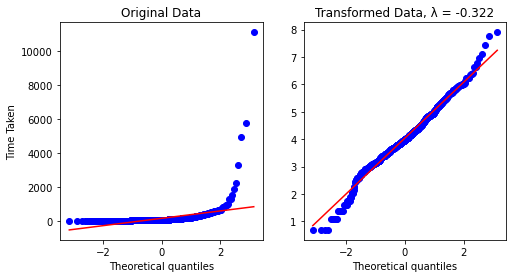

In [36]:
# step 4: IQR outlier removal
h2_jp_df_cleansed = remove_outlier_IQR(h2_jp_df, 'time_trans', 15, 85)
test_distribution(h2_jp_df['time'], h2_jp_df_cleansed['time_trans'])
shapiro_wilk(h2_jp_df_cleansed['time_trans'])

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


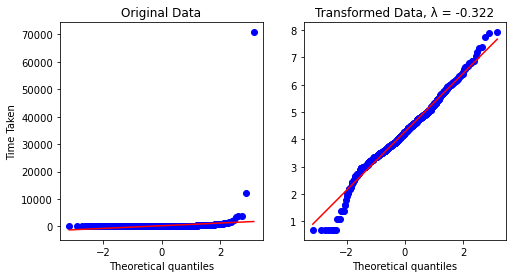

In [37]:
# step 4: IQR outlier removal
h2_tl_df_cleansed = remove_outlier_IQR(h2_tl_df, 'time_trans', 15, 85)
test_distribution(h2_tl_df['time'], h2_tl_df_cleansed['time_trans'])
shapiro_wilk(h2_tl_df_cleansed['time_trans'])

Statistics=0.990, p=0.000
Sample does not look Gaussian (reject H0)


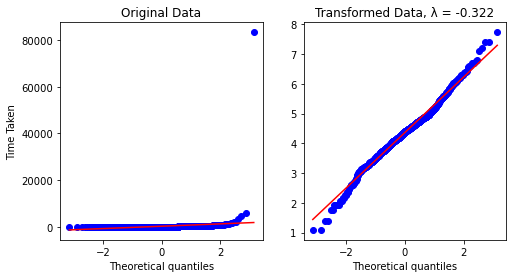

In [38]:
# step 4: IQR outlier removal
h2_an_df_cleansed = remove_outlier_IQR(h2_an_df, 'time_trans', 15, 85)
test_distribution(h2_an_df['time'], h2_an_df_cleansed['time_trans'])
shapiro_wilk(h2_an_df_cleansed['time_trans'])

## H3

In [39]:
# step 1: create data groups (tl vs an)
h3_tl_df = original_df.loc[original_df['temporal_enc'] == 'tl']
h3_an_df = original_df.loc[original_df['temporal_enc'] == 'an']

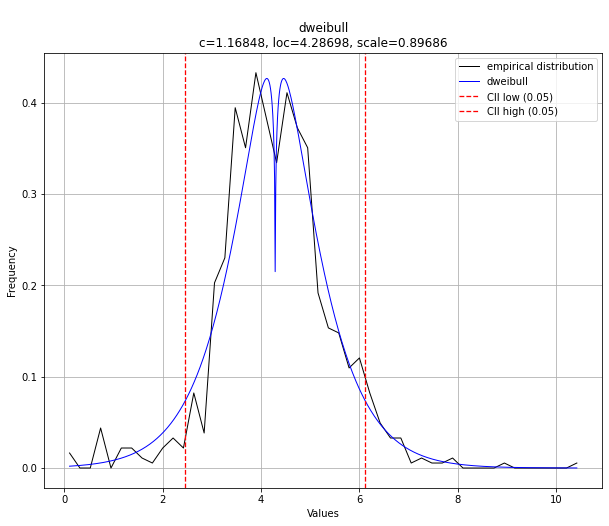

In [40]:
# step 2: check data distribution
check_dist(box_cox(h3_tl_df['time']))

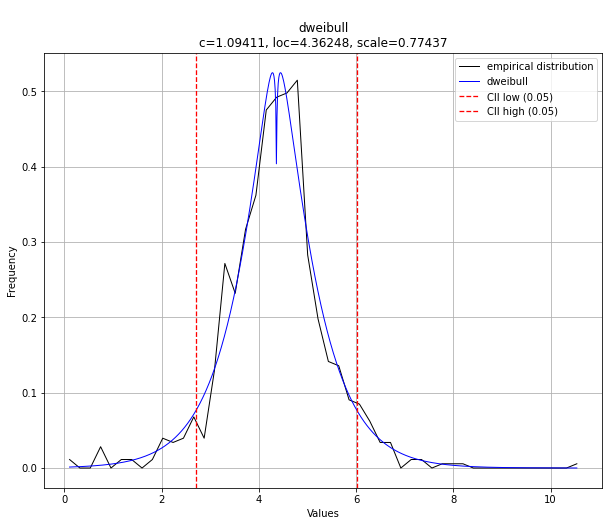

In [41]:
# step 2: check data distribution
check_dist(box_cox(h3_an_df['time']))

Statistics=0.971, p=0.000
Sample does not look Gaussian (reject H0)


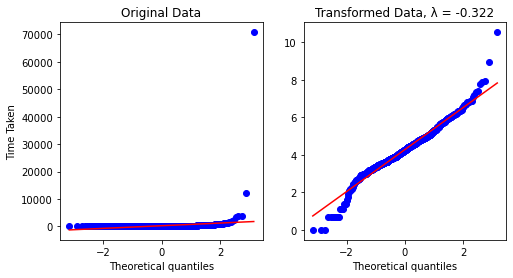

In [42]:
# step 3: transform using box cox and compare before and after
transform_data(h3_tl_df)

Statistics=0.962, p=0.000
Sample does not look Gaussian (reject H0)


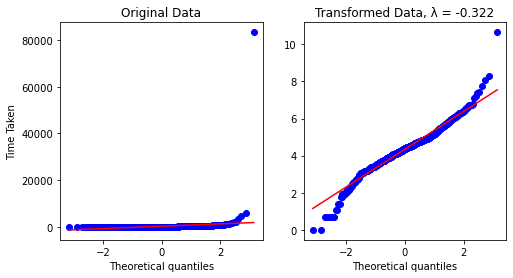

In [43]:
# step 3: transform using box cox and compare before and after
transform_data(h3_an_df)

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


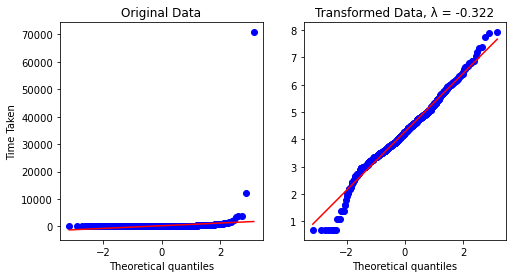

In [44]:
# step 4: IQR outlier removal
h3_tl_df_cleansed = remove_outlier_IQR(h3_tl_df, 'time_trans', 15, 85)
test_distribution(h3_tl_df['time'], h3_tl_df_cleansed['time_trans'])
shapiro_wilk(h3_tl_df_cleansed['time_trans'])

Statistics=0.990, p=0.000
Sample does not look Gaussian (reject H0)


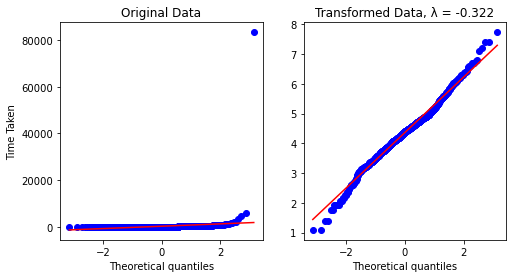

In [45]:
# step 4: IQR outlier removal
h3_an_df_cleansed = remove_outlier_IQR(h3_an_df, 'time_trans', 15, 85)
test_distribution(h3_an_df['time'], h3_an_df_cleansed['time_trans'])
shapiro_wilk(h3_an_df_cleansed['time_trans'])

## H4

In [46]:
# step 1: create data groups (a vs b)
h4_a_df = original_df.loc[original_df['group'] == 'A']
h4_b_df = original_df.loc[original_df['group'] == 'B']

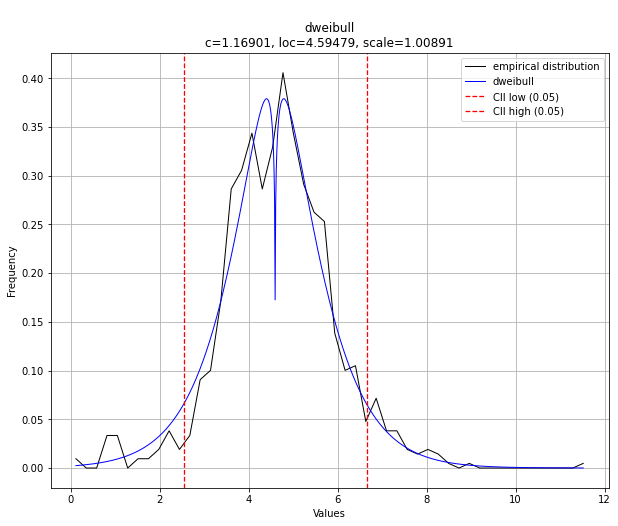

In [47]:
# step 2: check data distribution
check_dist(box_cox(h4_a_df['time']))

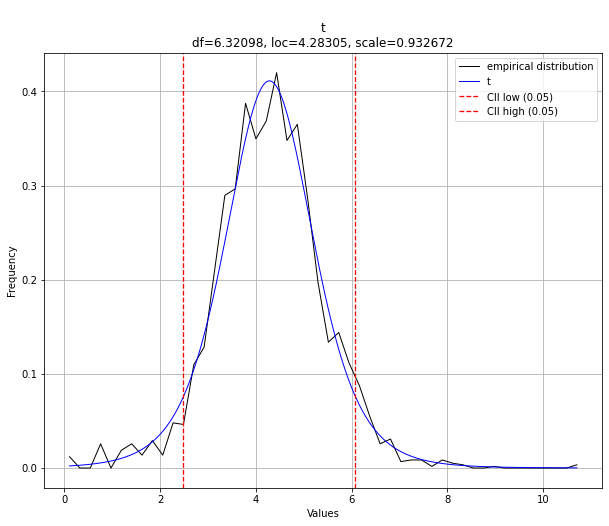

In [48]:
# step 2: check data distribution
check_dist(box_cox(h4_b_df['time']))

Statistics=0.979, p=0.000
Sample does not look Gaussian (reject H0)


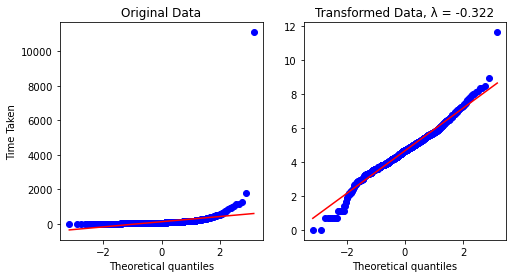

In [49]:
# step 3: transform using box cox and compare before and after
transform_data(h4_a_df)

Statistics=0.982, p=0.000
Sample does not look Gaussian (reject H0)


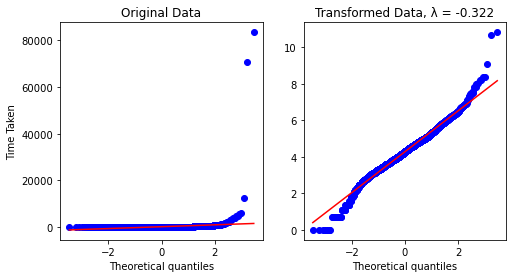

In [50]:
# step 3: transform using box cox and compare before and after
transform_data(h4_b_df)

Statistics=0.986, p=0.000
Sample does not look Gaussian (reject H0)


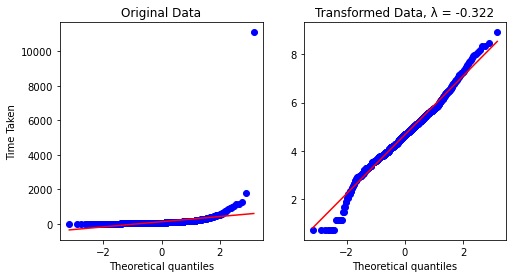

In [51]:
# step 4: IQR outlier removal
h4_a_df_cleansed = remove_outlier_IQR(h4_a_df, 'time_trans', 15, 85)
test_distribution(h4_a_df['time'], h4_a_df_cleansed['time_trans'])
shapiro_wilk(h4_a_df_cleansed['time_trans'])

Statistics=0.991, p=0.000
Sample does not look Gaussian (reject H0)


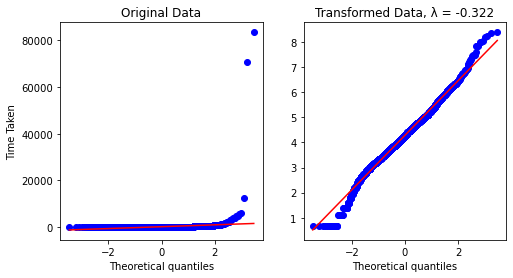

In [52]:
# step 4: IQR outlier removal
h4_b_df_cleansed = remove_outlier_IQR(h4_b_df, 'time_trans', 15, 85)
test_distribution(h4_b_df['time'], h4_b_df_cleansed['time_trans'])
shapiro_wilk(h4_b_df_cleansed['time_trans'])

## H5

In [53]:
# step 1: create data groups (tl vs an)
h5_nl_df = original_df.loc[original_df['network_enc'] == 'nl']
h5_m_df = original_df.loc[original_df['network_enc'] == 'm']

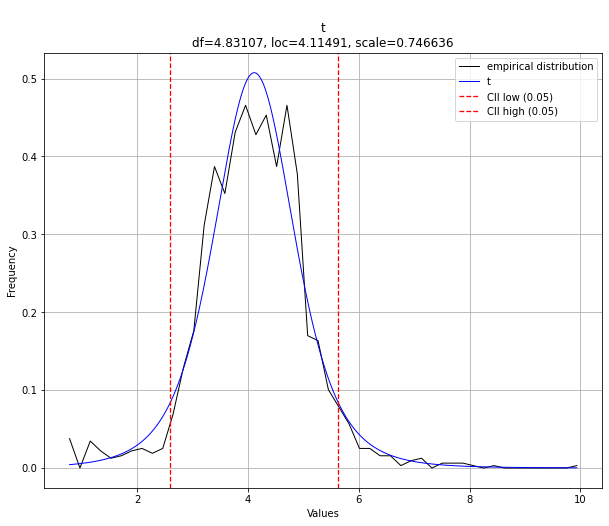

In [54]:
# step 2: check data distribution
check_dist(box_cox(h5_nl_df['time']))

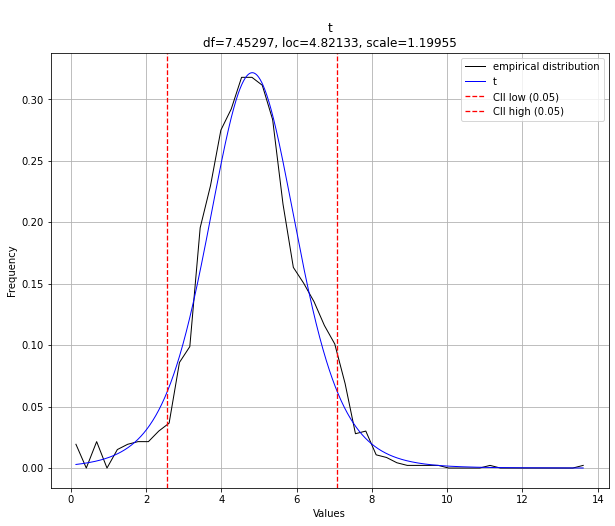

In [55]:
# step 2: check data distribution
check_dist(box_cox(h5_m_df['time']))

Statistics=0.965, p=0.000
Sample does not look Gaussian (reject H0)


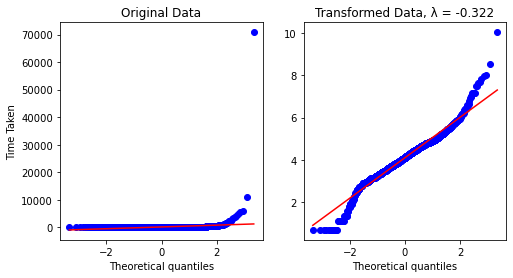

In [56]:
# step 3: transform using box cox and compare before and after
transform_data(h5_nl_df)

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


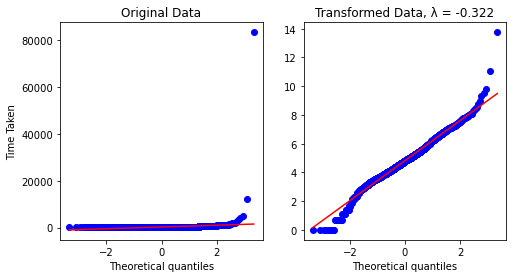

In [57]:
# step 3: transform using box cox and compare before and after
transform_data(h5_m_df)

Statistics=0.974, p=0.000
Sample does not look Gaussian (reject H0)


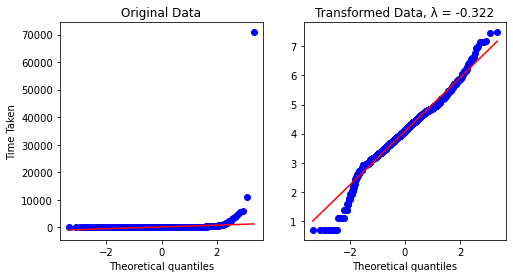

In [58]:
# step 4: IQR outlier removal
h5_nl_df_cleansed = remove_outlier_IQR(h5_nl_df, 'time_trans', 15, 85)
test_distribution(h5_nl_df['time'], h5_nl_df_cleansed['time_trans'])
shapiro_wilk(h5_nl_df_cleansed['time_trans'])

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


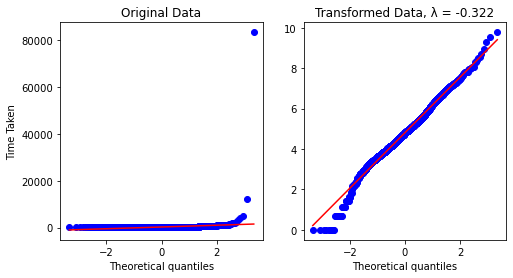

In [59]:
# step 4: IQR outlier removal
h5_m_df_cleansed = remove_outlier_IQR(h5_m_df, 'time_trans', 15, 85)
test_distribution(h5_m_df['time'], h5_m_df_cleansed['time_trans'])
shapiro_wilk(h5_m_df_cleansed['time_trans'])

In [60]:
# step 5: further subdivide based on task type
# single vs clique for nl
h5_nl_single_df = h5_nl_df.loc[h5_nl_df['task_entity'] == 'single']
h5_nl_clique_df = h5_nl_df.loc[h5_nl_df['task_entity'] == 'clique']

# single vs clique for m
h5_m_single_df = h5_m_df.loc[h5_m_df['task_entity'] == 'single']
h5_m_clique_df = h5_m_df.loc[h5_m_df['task_entity'] == 'clique']

## H6